In [1]:
# this is where I will implement the WaveNet model for makemore
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# load all harry potter books as text into a list
text: list[str] = []
for i in range(1, 3):
    with open(f"harry-potter/book{i}.txt") as f:
        text += list(f.read())

In [3]:
# print first 100 characters
print("".join(text[:100]))

/ 




THE BOY WHO LIVED 

Mr. and Mrs. Dursley, of number four, Privet Drive, 
were proud to say th


In [4]:
# look up table encoder decoder from letters in words to numbers
def make_encoder_decoder(words: list[str]) -> tuple[dict[str, int], dict[int, str]]:
    letters = sorted(set("".join(words)))
    encoder = {letter: i for i, letter in enumerate(letters)}
    decoder = {i: letter for i, letter in enumerate(letters)}
    return encoder, decoder

In [5]:
# partition the dataset into sequences
def make_sequences(x: torch.Tensor, sequence_size: int) -> torch.Tensor:
    sequences = []
    for i in range(0, x.shape[0] - sequence_size):
        sequences.append(x[i:i+sequence_size])
    return torch.stack(sequences)

In [6]:
# partition the dataset into mini batches randomly and return the batches
def make_batches(x: torch.Tensor, batch_size):
    n = x.shape[0]
    indices = torch.randperm(n)
    x = x[indices]
    for i in range(0, n, batch_size):
        xs = x[i:i+batch_size]
        # batches.append((x[i:i+batch_size, :-1], x[i:i+batch_size, -1]))
        yield x[i:i+batch_size, :-1], x[i:i+batch_size, -1]


In [7]:
len(text)

1006137

In [8]:
encoder, decoder = make_encoder_decoder(text)
sequence_length = 128
# create the dataset
all_letters = torch.tensor([encoder[letter] for letter in text], dtype=torch.long)
sequences = make_sequences(all_letters, sequence_length + 1).to("mps")

In [9]:
sequences.shape

torch.Size([1006008, 129])

In [10]:
class ResidualBlock(nn.Module):
    def __init__(self, channel_dim, dilation):
        super(ResidualBlock, self).__init__()
        # filter and gate conv concatenated
        self.conv = nn.Conv1d(channel_dim, channel_dim*2, 2, padding="same", dilation=dilation)
        self.batch_norm = nn.BatchNorm1d(channel_dim)

    def forward(self, input):
        output = self.conv(input)
        filter_output = torch.tanh(output[:, :output.shape[1]//2])
        gate_output = torch.sigmoid(output[:, output.shape[1]//2:])
        output = filter_output * gate_output
        output = self.batch_norm(output)
        return output + input

class WaveNet(nn.Module):
    def __init__(self, sequence_length: int):
        super(WaveNet, self).__init__()
        # embedding layer
        self.embedding = nn.Embedding(len(encoder), 32)
        # assume input of sequence length 128
        # residual blocks
        self.residual_blocks = nn.Sequential(
            ResidualBlock(32, 1),
            ResidualBlock(32, 2),
            ResidualBlock(32, 4),
            ResidualBlock(32, 8),

        )
        self.conv = nn.Conv1d(32, 1, 2, padding="same", dilation=16)
        self.batch_norm1 = nn.BatchNorm1d(sequence_length)
        # linear layer
        self.linear1 = nn.Linear(sequence_length, len(encoder), bias=False)
        self.batch_norm2 = nn.BatchNorm1d(len(encoder))
        self.linear2 = nn.Linear(len(encoder), len(encoder), bias=False)
        # make the model initially less confident
        self.linear2.weight.data *= 0.1


    def forward(self, x: torch.Tensor):
        x = self.embedding(x)
        # make input shape into (batch_size, channels, sequence_length)
        x = x.permute(0, 2, 1)
        x = self.residual_blocks(x)
        x = torch.relu(self.conv(x)).squeeze(1)
        x = self.batch_norm1(x)
        x = self.linear1(x)
        x = self.batch_norm2(x)
        x = self.linear2(x)
        return x

In [17]:
# set up the model
model = WaveNet(sequence_length).to("mps")
# load the model and optimizer from checkpoint
checkpoint = torch.load("checkpoint.pt", map_location="mps")
model.load_state_dict(checkpoint["model_state_dict"])
model.requires_grad_(True)
# set up the optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

In [15]:
losses = []

In [66]:
# training loop
max_iters = 25
batch_size = 64
num_batches = sequences.shape[0] // batch_size
model.train().to("mps")
for i in range(max_iters):
    for batch_num, (x, y) in enumerate(make_batches(sequences, batch_size)):
        y_hat = model(x)
        loss = F.cross_entropy(y_hat.squeeze(), y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        if batch_num % 100 == 0:
            print(f"epoch: {i}, batch: [{batch_num:>4d}/{num_batches:>4d}], loss: {loss.item():.4f}")
    
    print(f"epoch: {i}, loss: {loss.item()}")

# save checkpoint of model (optimizer and model state dict)
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "loss": loss
}, "checkpoint.pt")

epoch: 0, batch: [   0/15718], loss: 2.0166
epoch: 0, batch: [ 100/15718], loss: 1.9003
epoch: 0, batch: [ 200/15718], loss: 1.6796
epoch: 0, batch: [ 300/15718], loss: 1.8588
epoch: 0, batch: [ 400/15718], loss: 1.4960
epoch: 0, batch: [ 500/15718], loss: 1.9760
epoch: 0, batch: [ 600/15718], loss: 1.7551
epoch: 0, batch: [ 700/15718], loss: 1.7700
epoch: 0, batch: [ 800/15718], loss: 1.7182
epoch: 0, batch: [ 900/15718], loss: 2.0835
epoch: 0, batch: [1000/15718], loss: 1.8963
epoch: 0, batch: [1100/15718], loss: 1.7958
epoch: 0, batch: [1200/15718], loss: 2.1486
epoch: 0, batch: [1300/15718], loss: 1.6020


KeyboardInterrupt: 

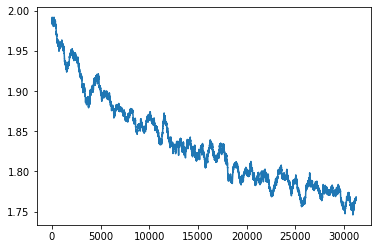

In [67]:
# display the loss
# smoothed losses
smoothed_losses = []
for i in range(0, len(losses)):
    smoothed_losses.append(sum(losses[i:i+500]) / 500)

plt.plot(smoothed_losses[:-500])
# plt.plot(losses)

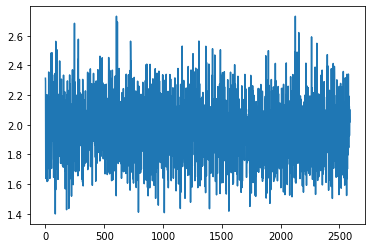

In [21]:
plt.plot(losses)

In [69]:
# save model weights
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "loss": loss
}, "checkpoint.pt")

In [28]:
# generate text
sequence_length = 128
@torch.no_grad()
def generate_text(model, start_text: str, length: int) -> str:
    # encode the start text
    encoded_text = torch.tensor([encoder[letter] for letter in list(start_text)], dtype=torch.long)
    # generate the text
    for i in range(length):
        # get the next letter
        y_hat = model(encoded_text[-sequence_length:].unsqueeze(0))
        y_hat = y_hat.squeeze()
        y_hat = F.softmax(y_hat, dim=0)
        # sample from the distribution
        next_letter = torch.multinomial(y_hat, 1)
        # add the letter to the encoded text
        encoded_text = torch.cat((encoded_text, next_letter))
    # decode the text
    decoded_text = "".join([decoder[letter.item()] for letter in encoded_text])
    return decoded_text

In [68]:
# load and test model
# model = WaveNet(sequence_length).to("mps")
# model.load_state_dict(torch.load("wavenet_seqlength128.pth", map_location="mps"))
new_model = model.eval().cpu()

# start text of length 128 characters
start_text = "THE BOY WHO LIVED \nMr. and Mrs. Dursley, of number four, Privet Drive, \nwere proud to say that they were perfectly normal \nthank you very much. They were the last people you’d "
# generate text
generated_text = generate_text(new_model, start_text, 1500)
print(generated_text)

THE BOY WHO LIVED 
Mr. and Mrs. Dursley, of number four, Privet Drive, 
were proud to say that they were perfectly normal 
thank you very much. They were the last people you’d wa bettamg, Exaptisbit the hard, Ron choot: Weet 
fank shrrusis, Potter and mwenching of the back.” 

The He the Slytherin Ron ’Cat red, in not, sraood betone quones, Malth 
wands end alonging,” Hexsy was hiWding sowelged 
mad youe wicging,” sid: 
sites nomumck, gumuzents his 
shoak 
fime,” hy exnry,” Harry him quimker 
crimon. Uucgy hidgling imneamemy bved first imls finny 




Flast Gringer slives waut wly at igle?s 
wa vone 
plaking of that to 
Harryss bepwh he cametiwe thrirled in face fre anNest and stush, nipes abtedt sa
Minh 
butt hirl you sifting 
lele and pook the taramfel now problowand neached of ‘only. 

Proth sidlirs poalzy talch at, Rigked . 

Nack cood, he cook the thead wout ever, deam.” 



Lotled. And soalk to dite Professor Mleble, out 
saud?” srofty to chack ning and Ginb, 
at, to do lilently,